# 📜Summary
**Introduction:** Efficient operations in the airline industry hinge on maximizing the number of flights to optimize revenue. However, maintaining a tight schedule poses a significant risk of network delays. A single delayed flight not only impacts its immediate successor but can ripple through subsequent flights, amplifying disruptions across the network. This is why Airlines does it best to improve their On-Time Performance.

**Problem:** How can we maximize the number of flights while mitigating the risk of disruption?

**Hypothesis:** If we are able to know the chances of a flight being delayed, we  can plan our flight schedules better.

**Goal:** Predict the probability of delays for flights.

[kaggle](https://www.kaggle.com/code/fiftythirtyfour/usa-airline-on-time-performance/edit)

# 🤓Data Science

In [1]:
# ! pip install airportsdata
! pip install timezonefinder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime as dt
# import airportsdata as ap
from timezonefinder import TimezoneFinder

warnings.filterwarnings("ignore")
pd.options.display.max_columns = 200
pd.options.display.max_rows = 400

In [3]:
## Load
df = pd.read_csv('/kaggle/input/flight-delays/flights.csv')
airl = pd.read_csv('/kaggle/input/flight-delays/airlines.csv')
airp = pd.read_csv('/kaggle/input/flight-delays/airports.csv')

## Cleaning
df.columns = df.columns.str.lower()
airp.columns = airp.columns.str.lower()

airp.loc[airp['iata_code'] == "UST", ["latitude", "longitude"]] = (29.95815, -81.34163)
airp.loc[airp['iata_code'] == "ECP", ["latitude", "longitude"]] = (30.3583, -85.7956)
airp.loc[airp['iata_code'] == "PBG", ["latitude", "longitude"]] = (44.6509, -73.4663)

df['scheduled_departure'] = [dt.time(x // 100, x % 100) for x in df['scheduled_departure']]
df['std_date'] = pd.to_datetime(df[['year', 'month', 'day']])

df['std_date_time'] = pd.to_datetime(df['std_date'].astype(str) + ' ' + df['scheduled_departure'].astype(str))
df['sta_date_time'] = df['std_date_time'] + pd.to_timedelta(df['scheduled_time'], unit='m')
df['atd_date_time'] = df['std_date_time'] + pd.to_timedelta(df['departure_delay'], unit='m')
df['ata_date_time'] = df['atd_date_time'] + pd.to_timedelta(df['elapsed_time'], unit='m')

df['anchor'] = df['airline'] + [str(x).zfill(5) for x in df['flight_number']] + '|' + df['std_date'].dt.strftime('%Y-%m-%d') + '|' + df['origin_airport'].astype(str)
df['otp_dly15'] = np.where(df['departure_delay'] > 15, 0.0, 1.0)

## Organize
dly = [x for x in df.columns if 'delay' in x]
num = [x for x in df.columns if df.dtypes[x] in ('float', 'int64')]
cat = [x for x in df.columns if df.dtypes[x] == "object"]
target = 'departure_delay'
num.remove(target)

## Split
train = df.query('airline not in ("AA", "US", "OO")')
test = df.query('airline == "OO"')

In [4]:
def getTimezone(latlon):
    lat, lon = latlon
    tf = TimezoneFinder()
    return tf.timezone_at(lat=lat, lng=lon)

In [5]:
airp.loc[airp['latitude'].isnull()][['iata_code', 'latitude', 'longitude']]

,iata_code,latitude,longitude


In [6]:
%%time
airp[['latitude', 'longitude']].apply(getTimezone, axis=1)

CPU times: user 3min 23s, sys: 1min 51s, total: 5min 14s
Wall time: 5min 15s


0                  America/New_York
1                   America/Chicago
2                    America/Denver
3                   America/Chicago
4                  America/New_York
5                  America/New_York
6                   America/Chicago
7               America/Los_Angeles
8                  America/New_York
9                      America/Adak
10                America/Anchorage
11                  America/Chicago
12                 America/New_York
13                America/Anchorage
14                 America/New_York
15                  America/Chicago
16                  America/Chicago
17                America/Anchorage
18                  America/Detroit
19                   America/Denver
20                 America/New_York
21                  America/Chicago
22                  America/Chicago
23                 America/New_York
24                 America/New_York
25                  America/Detroit
26                 America/New_York
27                America/An

# 🤓Data Science

In [7]:
train.corr(numeric_only=True)[target].sort_values(ascending=False)

departure_delay        1.000000
arrival_delay          0.944818
airline_delay          0.587769
late_aircraft_delay    0.559684
weather_delay          0.251968
departure_time         0.181721
wheels_off             0.171962
air_system_delay       0.128953
scheduled_arrival      0.107135
taxi_out               0.065530
wheels_on              0.057823
arrival_time           0.047801
cancelled              0.035646
elapsed_time           0.033674
scheduled_time         0.029432
distance               0.025458
diverted               0.025350
air_time               0.025053
taxi_in                0.023484
security_delay         0.011277
day                   -0.000214
flight_number         -0.006996
day_of_week           -0.014607
month                 -0.024249
otp_dly15             -0.659777
year                        NaN
Name: departure_delay, dtype: float64

# > Merger of American and US Airways
There was a Merger of American Airlines and US Airways in June 2015. Southwest, Delta and American Airlines have the biggest voume of flights in 2015.

In [8]:
# g = df.pivot_table('flight_number', index='airline'
#               , columns=[df['year'], df['month']]
#               , aggfunc='count') / 1000
# g.index = g.index.map(rairline.set_index('IATA_CODE')['AIRLINE'])
# sns.heatmap(g, cmap='RdBu', annot=True, fmt='.0f')

# plt.title("Volume Count by Airline by thousands");

# > Airline Departure On-Time Performance.
Lower volume flights like Hawaiian, Virgin and Alaska Airlines are almost always on time. Delta and American airlines are also on time taking into consideration that they have more flights in 2015.

In [9]:
# g = train.query('cancelled == 0 and diverted == 0')
# g = g.pivot_table(target, index='airline'
#              , columns=[g['year'], g['std_date'].dt.month]
#              , aggfunc='mean')  * 100
# g.index = g.index.map(rairline.set_index('IATA_CODE')['AIRLINE'])
# sns.heatmap(g, annot=True, cmap='RdBu')
# plt.title('Average On-Time Flights by Airline');

# > Flight Plan

In [10]:
vx = train.query('airline=="VX"')

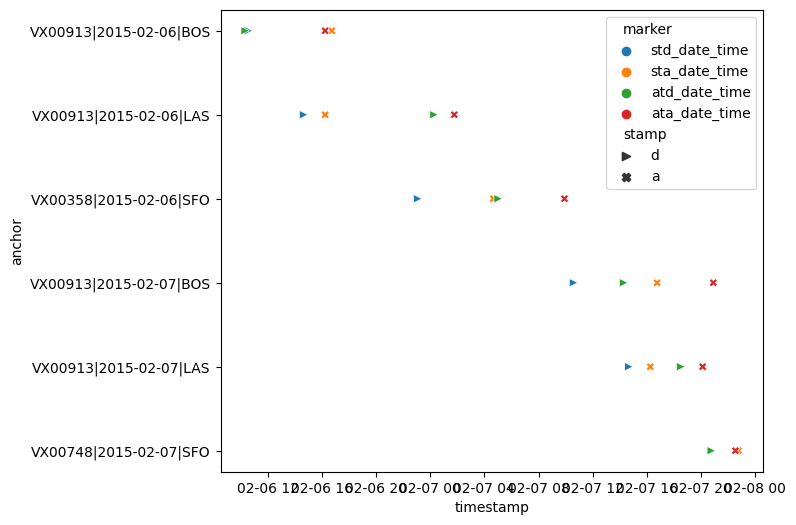

In [11]:
g = vx.query('tail_number == "N361VA"')
g = g.query('"2015-02-06" <= std_date <= "2015-02-07"')
g = g.loc[~g['departure_delay'].isnull()]
g = g[[
    'anchor'
    ,'std_date_time'
   , 'sta_date_time'    
   , 'atd_date_time'
   , 'ata_date_time'
#    , 'scheduled_time'
#        , 'elapsed_time'
#        , 'scheduled_arrival'
#        , 'arrival_time'
#        , 'arrival_delay'
#        , 'late_aircraft_delay'
#     , target
      ]]

g = g.sort_values(by='std_date_time')
# g['diff'] = (g['ata_date_time'] - g['sta_date_time']).dt.total_seconds() / 60
# g
g = pd.melt(g, id_vars='anchor', var_name='marker', value_name='timestamp')
g['stamp'] = g['marker'].str[2:3]
fig, ax = plt.subplots(figsize=(7,6))
sns.scatterplot (g, x='timestamp', y='anchor'
                 , hue='marker'
                 , style='stamp'
                 , markers={'d': '>', 'a': 'X'}
                 , ax=ax);

In [12]:
# df['std_ls_date_time'] = df[['std_date_time', 'tz']].apply(lambda x: 
#                                   x['std_date_time'].tz_localize(
#                                       x['tz'], ambiguous='NaT')
#                                   if pd.notna(x['std_date_time']) 
#                                   and pd.notna(x['tz']) else pd.NaT, axis=1)